## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
import pickle

# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def gini(sequence):
    c1, c2, l = 0, 0, len(sequence)
    for i in range(l):
        if sequence[i] == 1:    # count class 1
            c1 += 1
        else:                   # count class 2
            c2 += 1
    p1, p2 = c1 / l, c2 / l     # count prob. of each class
    return 1 - p1 ** 2 - p2 ** 2

def entropy(sequence):
    c1, c2, l = 0, 0, len(sequence)
    for i in range(l):
        if sequence[i] == 1:    # count class 1
            c1 += 1
        else:                   # count class 2
            c2 += 1
    p1, p2 = c1 / l, c2 / l     # count prob. of each class
    if not p1 or not p2:        # all in same class
        return 0
    else:
        return -p1 * np.log2(p1) - p2 * np.log2(p2)

In [2]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [3]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [4]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [5]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)

# extract labels from dataset
y_train, y_val = train_df['price_range'], val_df['price_range']
x_train, x_val = train_df.drop(columns=['price_range']), val_df.drop(columns=['price_range'])

train_df.head()

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [6]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        # initialzation
        self.max_depth = max_depth
        self.root = None
        self.criterion = None
        self.feature_importances = [0] * 20

        if criterion == 'gini':
            self.criterion = gini
        else:
            self.criterion = entropy

    def fit(self, x_data, y_data, rf=None): # this is the train function
        self.rf = rf
        # deal with different input type
        if isinstance(x_data, pd.DataFrame):
            dataset = x_data.values.tolist()
        else:
            dataset = x_data
        # merge x_data and y_data
        train_dataset = [list(dataset[i]) + [y_data[i]] for i in range(len(y_data))]
        # build the tree
        self.root = self.best_split(train_dataset)
        self.split_tree(self.root, self.max_depth, 1)

    def predict(self, x_data):
        # deal with different input type
        if isinstance(x_data, pd.DataFrame):
            dataset = x_data.values.tolist()
        else:
            dataset = x_data
        # return prediction of each data
        ret = [self.predict_data(dataset[i], self.root) for i in range(len(x_data))]
        return ret

    def predict_data(self, data, node):
        # split predict data with attribute and threshold of each node
        if data[node['attribute']] <= node['threshold']:
            if isinstance(node['left'], dict):
                return self.predict_data(data, node['left'])
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict_data(data, node['right'])
            else:
                return node['right']

    def test_split(self, attribute, threshold, dataset):
        # split dataset base on given attribute and threshold
        left, right = [], []
        for i in range(len(dataset)):
            if dataset[i][attribute] <= threshold:
                left.append(dataset[i])
            else:
                right.append(dataset[i])
        return left, right

    def best_split(self, dataset):
        b_purity, b_attribute, b_threshold, b_left, b_right = 10, 999, 9000, None, None
        # generate random vector of random forest
        if self.rf != None:
            cols = np.random.choice(len(dataset[0]) - 1, int(self.rf), replace=False)
        for attribute in range(len(dataset[0]) - 1):
            # skip the attribute not in random vector of random forest
            if self.rf != None and attribute not in cols:
                continue
            # find unique threshold for the attribute
            thresholds = np.array([data[attribute] for data in dataset])
            thresholds = np.unique(thresholds)
            thresholds = np.sort(thresholds)
            # pop maximum to prevent left or right = None
            if len(thresholds) == 1:
                continue
            thresholds = thresholds[:-1]
            # iterate through thresholds to find best split
            for threshold in thresholds:
                left, right = self.test_split(attribute, threshold, dataset)
                split_purity = (self.criterion([row[-1] for row in left]) * len(left) + self.criterion([row[-1] for row in right]) * len(right)) / len(dataset)
                if split_purity < b_purity:
                    b_purity, b_attribute, b_threshold, b_left, b_right = split_purity, attribute, threshold, left, right
        return {'attribute':b_attribute, 'threshold':b_threshold, 'left':b_left, 'right':b_right}

    def leaf_pred(self, dataset):
        # output the most class in dataset
        c1, c2 = 0, 0
        for i in range(len(dataset)):
            if dataset[i][-1] == 0:
                c1 += 1
            else:
                c2 += 1
        if c1 > c2:
            return 0
        else:
            return 1

    def check_same_class(self, dataset):
        # check whether all data in the dataset are in the same class
        c = dataset[0][-1]
        for i in range(len(dataset)):
            if dataset[i][-1] != c:
                return False
        return True

    def split_tree(self, node, max_depth, cur_depth):
        # recursivly split the tree
        left, right = node['left'], node['right']
        del(node['left'])
        del(node['right'])
        # left or right = None -> predict
        if not left or not right:
            node['left'] = node['right'] = self.leaf_pred(left + right)
            return 
        # reach max depth -> predict
        if max_depth != None and cur_depth >= max_depth:
            node['left'], node['right'] = self.leaf_pred(left), self.leaf_pred(right)
            return
        
        if self.check_same_class(left):             # in the same class -> predict
            node['left'] = self.leaf_pred(left)
        else:
            node['left'] = self.best_split(left)    
            if node['left']['attribute'] == 999:    # if can not split anymore -> predict
                node['left'] = self.leaf_pred(left)
            else:                                   # keep split
                self.split_tree(node['left'], max_depth, cur_depth + 1)
        
        if self.check_same_class(right):            # in the same class -> predict
            node['right'] = self.leaf_pred(right)
        else:
            node['right'] = self.best_split(right)
            if node['right']['attribute'] == 999:   # if can not split anymore -> predict
                node['right'] = self.leaf_pred(right)
            else:                                   # keep split
                self.split_tree(node['right'], max_depth, cur_depth + 1)
            
    def print_tree(self, node, depth=0):
        # recursivly print the tree
        if isinstance(node, dict):
            print('%s[Attribute %d < %.3f]' % ((depth*'\t', (node['attribute']), node['threshold'])))
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
        else:
            print('%s[%s]' % ((depth*'\t', node)))

    def compute_feature_importance(self, node):
        # travel the tree to compute feature importance
        if isinstance(node, dict):
            self.feature_importances[node['attribute']] += 1
            self.compute_feature_importance(node['left'])
            self.compute_feature_importance(node['right'])

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [7]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)    # declare decision tree
clf_depth3.fit(x_train, y_train)                            # fit it with train data
y_pred_3 = clf_depth3.predict(x_val)                        # predict with validation data
print(f"max_depth = 3:  Accuracy of validation data = {accuracy_score(y_val, y_pred_3)}")

clf_depth10 = DecisionTree(criterion='gini', max_depth=10) 
clf_depth10.fit(x_train, y_train)                           
clf_depth10.compute_feature_importance(clf_depth10.root) 
y_pred_10 = clf_depth10.predict(x_val)
print(f"max_depth = 10: Accuracy of validation data = {accuracy_score(y_val, y_pred_10)}")

max_depth = 3:  Accuracy of validation data = 0.9166666666666666
max_depth = 10: Accuracy of validation data = 0.9366666666666666


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [8]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_train, y_train)
y_pred = clf_gini.predict(x_val)
print(f"criterion=gini:    Accuracy of validation data = {accuracy_score(y_val, y_pred)}")

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train, y_train)
y_pred = clf_entropy.predict(x_val)
print(f"criterion=entropy: Accuracy of validation data = {accuracy_score(y_val, y_pred)}")

criterion=gini:    Accuracy of validation data = 0.9166666666666666
criterion=entropy: Accuracy of validation data = 0.93


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

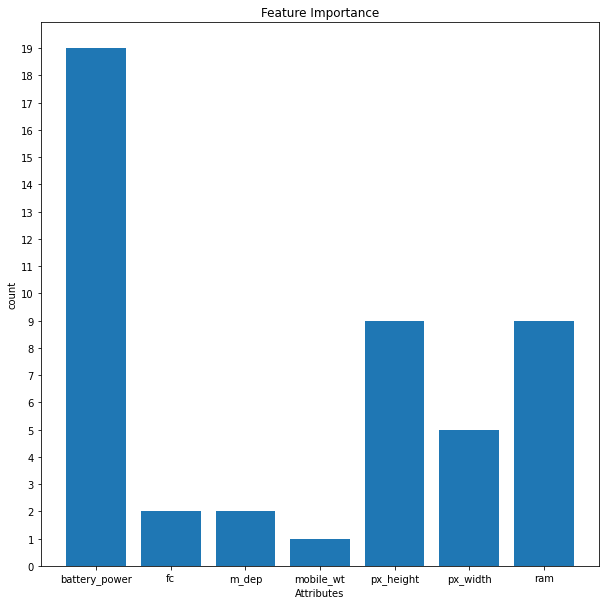

In [9]:
# plot feature importance
# extract column titles
attribute_temp = train_df.columns[0:-1]
attribute, importances = [], []

# only plot the feature with importance > 0
for i in range(len(clf_depth10.feature_importances)):
    if clf_depth10.feature_importances[i] != 0:
        attribute.append(attribute_temp[i])
        importances.append(clf_depth10.feature_importances[i])

plt.figure(figsize=(10, 10))
plt.bar(attribute, importances)
plt.xticks(np.arange(len(attribute)), attribute)
plt.yticks(np.arange(max(importances)+1))
plt.xlabel('Attributes')
plt.ylabel('count')
plt.title('Feature Importance')
plt.savefig('myimage.svg', format='svg', dpi=1200)
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [10]:
class AdaBoost():
    def __init__(self, n_estimators):
        # initialize
        self.n_estimators = n_estimators
        self.alphas = []
        self.clfs = []

    def fit(self, x_data, y_data):
        data_weight = np.full(len(x_data), (1 / len(x_data)))
        for n in range(self.n_estimators):
            # bootstrap with data weight
            rows = np.random.choice(len(x_data), len(x_data), p=data_weight)
            if isinstance(x_data, pd.DataFrame):
                dataset, labels = x_data.iloc[rows], y_data.iloc[rows].values.tolist()
            else:
                dataset = [x_data[row] for row in rows]
                labels  = [y_data[row] for row in rows]
            clf = DecisionTree(criterion='gini', max_depth=1)   # declare a decision tree
            clf.fit(dataset, labels)                            # fit with bootstrap data
            clf_predict = clf.predict(x_data)                   # predict with "all" data
            # compute error and alpha
            error = 0
            for i in range(len(rows)):
                if clf_predict[i] != y_data[i]:
                    error += data_weight[i]
            alpha = 0.5 * np.log((1 - error) / error)
            # update data weight
            for i in range(len(rows)):
                if y_data[i] == clf_predict[i]:
                    data_weight[i] *= np.exp(-alpha)
                else:
                    data_weight[i] *= np.exp(alpha)
            # normalize
            data_weight /= sum(data_weight)
            self.alphas.append(alpha)
            self.clfs.append(clf)

    def predict(self, x_data):
        out = np.full(len(x_data), 0.0)
        # compute wighted sum of each clf's prediction for each data
        for i in range(self.n_estimators):
            pred = self.clfs[i].predict(x_data)
            for j in range(len(x_data)):
                if pred[j] == 0:
                    out[j] -= self.alphas[i]
                else:
                    out[j] += self.alphas[i]
        # output the sign of each weighted prediction
        out = np.sign(out)
        # convert -1 to 0
        for i in range(len(out)):
            if out[i] == -1:
                out[i] = 0
        return np.asarray(out)

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [11]:
ada_10 = AdaBoost(n_estimators=10)
ada_10.fit(x_train, y_train)
y_pred = ada_10.predict(x_val)
print(f"n_estimators = 10:  Accuracy of validation data = {accuracy_score(y_val, y_pred)}")

ada_100 = AdaBoost(n_estimators=100)
ada_100.fit(x_train, y_train)
y_pred = ada_100.predict(x_val)
print(f"n_estimators = 100:  Accuracy of validation data = {accuracy_score(y_val, y_pred)}")

n_estimators = 10:  Accuracy of validation data = 0.94
n_estimators = 100:  Accuracy of validation data = 0.9633333333333334


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [12]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        # initialize
        self.n_estimators = n_estimators
        self.bootstrap = boostrap
        self.criterion = criterion
        self.max_features = max_features
        self.clfs = []
        self.max_depth = max_depth

    def fit(self, x_data, y_data):
        for _ in range(self.n_estimators):
            clf = DecisionTree(self.criterion, self.max_depth)
            # bootstrap or not
            if self.bootstrap == True:
                rows = np.random.choice(len(x_data), len(x_data))
                # deal with different input type
                if isinstance(x_data, pd.DataFrame):
                    dataset, labels = x_data.iloc[rows], y_data.iloc[rows].values.tolist()
                else:
                    dataset = [x_data[row] for row in rows]
                    labels  = [y_data[row] for row in rows]
            else:
                dataset, labels = x_data, y_data
            # fit clf with train data
            clf.fit(dataset, labels, self.max_features)
            self.clfs.append(clf)

    def predict(self, x_data):
        # predict all data with each clf
        p = []
        for i in range(self.n_estimators):
            t = self.clfs[i].predict(x_data)
            p.append(t)
        # select most vote for each data
        ans = []
        for i in range(len(x_data)):
            lt = [col[i] for col in p]
            ans.append(max(set(lt), key=lt.count))
        return ans

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [13]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10tree.fit(x_train, y_train)
y_pred = clf_10tree.predict(x_val)
print(f"n_estimators = 10:  Accuracy of validation data = {accuracy_score(y_val, y_pred)}")

clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100tree.fit(x_train, y_train)
y_pred = clf_100tree.predict(x_val)
print(f"n_estimators = 100:  Accuracy of validation data = {accuracy_score(y_val, y_pred)}")

n_estimators = 10:  Accuracy of validation data = 0.94
n_estimators = 100:  Accuracy of validation data = 0.9466666666666667


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [14]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features.fit(x_train, y_train)
y_pred = clf_random_features.predict(x_val)
print(f"random feature: Accuracy of validation data = {accuracy_score(y_val, y_pred)}")

clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features.fit(x_train, y_train)
y_pred = clf_all_features.predict(x_val)
print(f"all feature:    Accuracy of validation data = {accuracy_score(y_val, y_pred)}")

random feature: Accuracy of validation data = 0.93
all feature:    Accuracy of validation data = 0.9633333333333334


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [15]:
def train_your_model(data):
    ## Define your model and training 
    if isinstance(data, pd.DataFrame):
        data = data.values.tolist()
    x_data, y_data = [row[0:-1] for row in data], [row[-1] for row in data]
    clf = AdaBoost(n_estimators=150)
    clf.fit(x_data, y_data)
    return clf

In [16]:
my_model = train_your_model(pd.concat([train_df, val_df]))

x_test = pd.read_csv('x_test.csv')
y_pred = my_model.predict(x_test)

with open('model.pickle', 'wb') as pkl_file:
    pickle.dump(my_model, pkl_file, protocol=pickle.HIGHEST_PROTOCOL)

np.save("y_pred.npy", y_pred)

In [17]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [18]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

In [19]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        # print(accuracy_score(y_test, y_pred))
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
